# <font color='purple'>Genetic Mutation classification for Cancer Diagnosis</font>
## <font color='purple'>(*Using Gene Data*)</font>

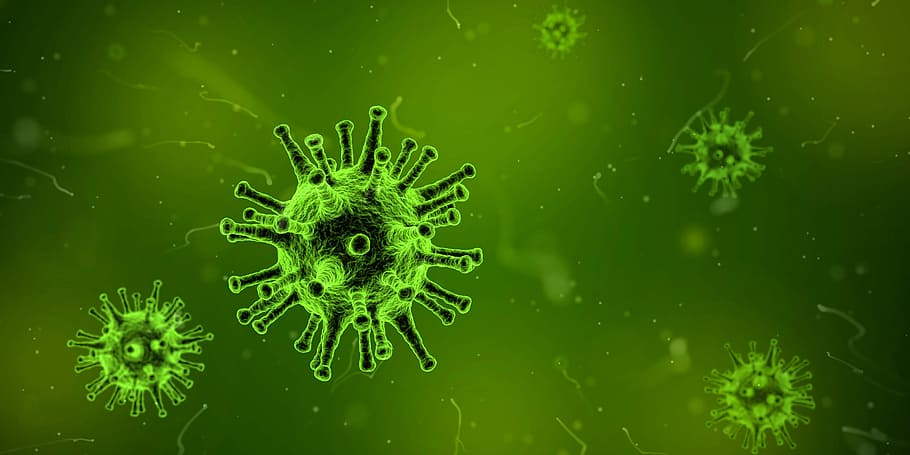

## <font color='blue'>STEP 1. What is the real world Business problem we're trying to solve?</font>

<font color='brown'>**DESCRIPTION OF PROBLEM:**</font>

* After sequencing,cancerous tumor can have **thousands of genetic mutations**. 

* We must find mutations that **contribute to tumor growth (drivers)** from the **neutral mutations (passengers).** 

<font color='brown'>**PROBLEM RESEARCHERS ARE CURRENTLY FACING:**</font>

* Currently this classification is being done manually. It's very time-consuming 

* A clinical pathologist will classify every single genetic mutation based on evidence from text-based clinical literature.

<font color='brown'>**WORKFLOW FOR A GENETIC SCIENTIST,FOR THIS TASK**</font>

* Genetic scientist decides the genetic mutation of interest
* there can be a GENE  -> and then there are MUTATIONS on genes
* both GENES and MUTATIONS can be thought of as CATEGORICAL random variable 
* the genes's mutaitons are classified into 9 categories -> some of those cause cancer. 
* It is scientist's duty to go though available literature for each mutation of each gene
* Finally, classify whether mutation is CANCEROUS or not i.e [Attach a **CLASS LABEL**]

<font color='brown'>**HELP DONE FOR US:**</font>
For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.



## <font color='blue'>STEP 2. WHAT ARE OBJECTIVES / CONSTRAINTS </font>

### 2.1 OBJECTIVE: Given a gene and text data on it : objective is to classify it into any of 9 categories, some of which may have cancer


### 2.2 CONSTRAINTS: 
#### 1. LOW LATENCY REQUIREMENT : NOT HERE 
#### 2. INTERPRETABILITY: IMPORTANT
* because let's say the ML algo gives me class label = 5 . I want to be really really sure, why it gave me this class label?
* So that next time, another person comes with same set of genetic problems and gets classified  in same class(5) as he should, I am able to determine he has SAME reason of getting that label(also allows doctor to **double check** the reason as being correct or not. 
* As a missclassification is VERY COSTLY . **So I want the model to explain itself.**

#### 3. ERRORS CAN BE VERY COSTLY 
* so penalize mistakes  ->metric can be log loss

#### 4. Probability of a data point belonging to each class is needed 

* IMP: as we will get RICHER info 
* so in 1st case ,the doctor is really sure patient belongs to class 1 
* in 2nd case: doctor is not very sure if patient SHOULD belong to class 1  -->so he will do more tests 


## 2.3 DATA

### 2.3.1 DATA OVERVIEW

* we have 2 files, 1 has info about genetic mutation and other has clinical evidence(text) that experts use to classify genetic mutations

* both files have common column called ID

* TRAINING IS COMPOSED OF 2 FILES:

**1) TRAINING DATA**

**2) TRAINING TEXT**

### 2.3.2 POSING THIS PROBLEM AS A REAL WORLD MACHINE LEARNING PROBLEM

#### THIS IS VERY IMP. We must figure what ML problem is it ? 

* THERE ARE **9 CLASSES**: this is **multi class classfication problem**


### 2.3.3 PERFORMANCE METRIC 
##### Multi class Log loss --> from business constraints, we want Probabilistic output 


##### Confusion Matrix  -->As we want to be really sure of rejection


### 2.3.4: BREAKING DATA INTO TRAINING, VALIDATION AND TEST RANDOMLY

* Break data as :

1) **TRAINING: 64%**

2) **CROSS VALIDATION : 16 %**

3) **TEST: 20%** 


# 3:PERFORMING EDA

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 
import numpy as np 

import time
import warnings 


from nltk.corpus import stopwords

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter 
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import math 
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
from sklearn.ensemble import StackingClassifier
from sklearn import model_selection

from sklearn import model_selection 
from sklearn.linear_model import LogisticRegression


## 3.1 READING DATA 

### 3.1.1 READING GENE AND VARIATION DATA 

In [2]:
data = pd.read_csv('training_variants')  # contains genes, variations, class label
print('NUMBER OF DATA POINTS' , data.shape[0])
print('NUMBER OF FEATURES' , data.shape[1])
print('FEATURES ARE ', list(data.columns))
data.head()


NUMBER OF DATA POINTS 3321
NUMBER OF FEATURES 4
FEATURES ARE  ['ID', 'Gene', 'Variation', 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


**BRIEF OVERVIEW**:

1. **ID**:         ID of row that links mutation to clinical evidence
2. **Gene**:       gene where this genetic mutation is located
3. **Variation** : The aminoacid change for this mutation
4. **Class**:      1-9

### 3.1.2: READ THE TEXT DATA 

In [3]:
data_text = pd.read_csv("training_text" , sep="\|\|"  ,engine="python",names=["ID","TEXT"],skiprows=1)
data_text.head()

# after ID, text is present after '||' lines

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### 3.1.3. Preprocessing of text
* done to filter out useless data

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string
        

In [5]:

#text processing stage.
start_time = time.process_time()   # timing the process
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
        
    else:
        print("there is no text description for id:",index)
        
print('Time took for preprocessing the text :',time.process_time() - start_time, "seconds")



there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 184.734375 seconds


In [6]:
# now we merge both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [9]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


## 3.1.4. Test, Train and Cross Validation Split

### 3.1.4.1 : Splitting ratio : Train-Test-CV : [64 : 20 : 16]

In [1]:
y_true = result['Class'].values  # takes all values of class
result.Gene      = result.Gene.str.replace('\s+', '_')
# the regular expression \s matches a single whitespace character,
# while \s+ will match one or more whitespace characters

result.Variation = result.Variation.str.replace('\s+', '_') # do same with variation

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)


# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)



NameError: name 'result' is not defined

* We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])


Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### 3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets
* it's very important to verify that distribution of class labels in Train, test and CV is 
  roughly the same 

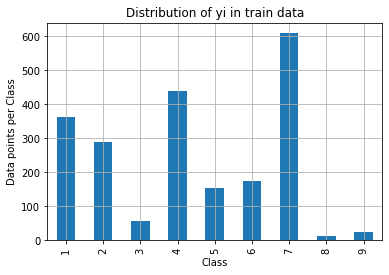

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


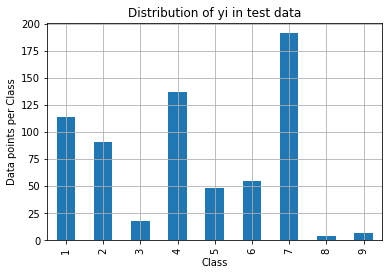

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


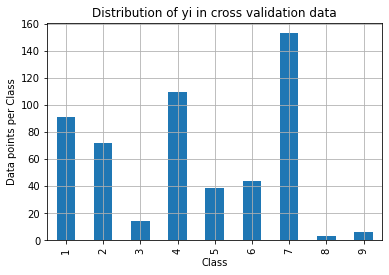

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [12]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')
    
    

**TAKEAWAYS**
* class 7 has highest amount of data, followed by class 4 and class 1
* classes 3 , 8 and 9 have very less data 
* Number of data points in each class is ~ same for all train, test and CV sets

**CONCLUSION**: 

* This is **imbalanced dataset** : i.e it's a multi class classification problem with imbalanced data present

* Distribution of class labels in Train, Test and CV sets is almost same! So ML modelling will work well

## 3.2 Prediction using a 'Random' Model
* Random model gives a 'threshold metric' , compared to which, the classifier I run should perform better.

* otherwise my classifier becomes worse than even a random model

* **In this 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1**

In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    
    

Log loss on Cross Validation Data using Random Model 2.490864442258701
Log loss on Test Data using Random Model 2.527304092464918
-------------------- Confusion matrix --------------------


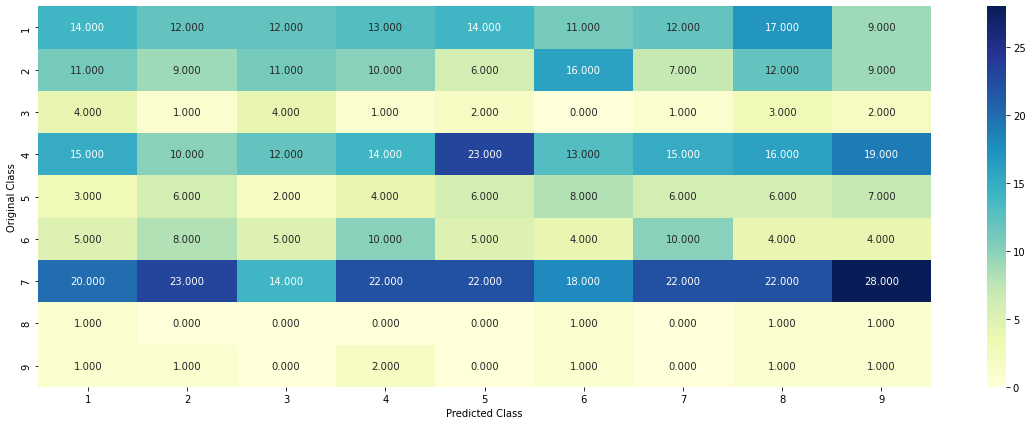

-------------------- Precision matrix (Columm Sum=1) --------------------


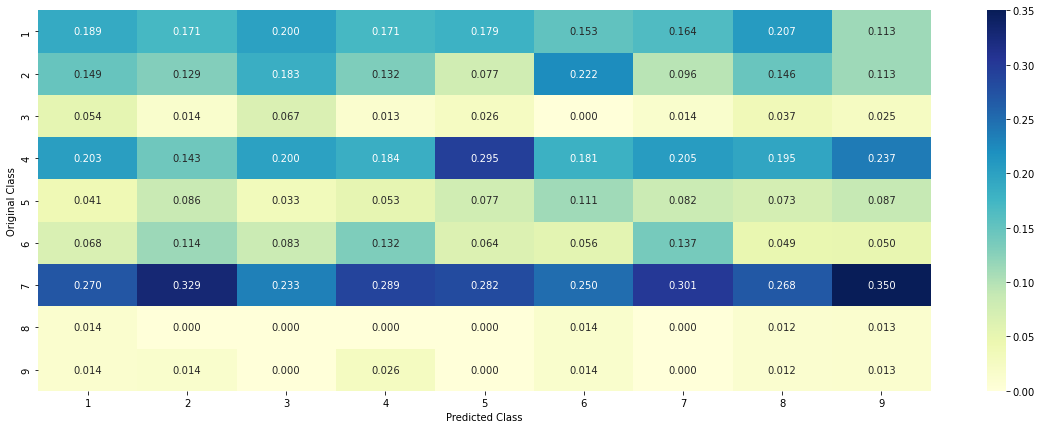

-------------------- Recall matrix (Row sum=1) --------------------


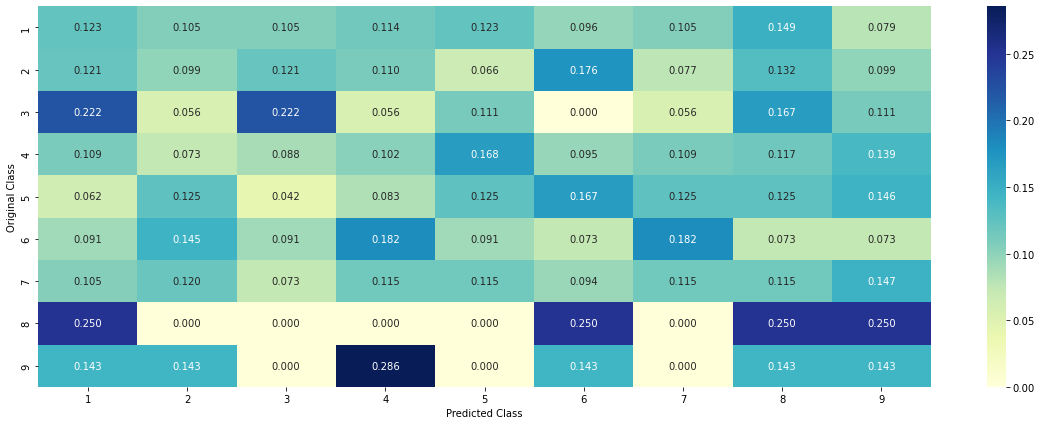

In [14]:
np.random.seed(0)  # else log loss values will keep on changing 

# we need to generate 9 numbers and the sum of numbers should be 1
# we are simulating a random classifer 
# one solution is to genarate 9 numbers and divide each of the numbers by their sum

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)  # this is key aspect here!
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)



**CONFUSION MATRIX**: 
- darker blue shade: means values are large 
- so 1-1 says 16 points are there that are actually class 1 and predicted to be class 1 
- ideally ,if a model is perfect, we want all DIAGONAL elements to be dark blue(or high)


**NOTE**: as expected, for a random model, the precision is very low 

**FOR IDEAL MODEL**: both precision and recall (the diagonal elements) should be **VERY HIGH**

## 3.3 Univariate Analysis

**We do it , in order to:**

- Consider each feature's relation w.r.t other features
- See if it;s useful in prediciting class label or not 
    


In [15]:

def get_gv_fea_dict(alpha, feature, df):

    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea




### 3.2.1 Univariate Analysis on Gene Feature

### Q1. What type of feature is gene feature ?
* CATEGORICAL VARIABLE

### Q2. How many categories are there and How they are distributed?

In [16]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(50))  # there are mnay more, these are only 10!!


Number of Unique Genes : 238
BRCA1     159
TP53      109
EGFR       88
PTEN       81
BRCA2      80
KIT        70
BRAF       54
ERBB2      45
ALK        41
PDGFRA     39
PIK3CA     38
FGFR2      34
TSC2       31
RET        31
MTOR       31
FLT3       30
CDKN2A     30
VHL        27
KRAS       27
MAP2K1     27
MET        25
NOTCH1     24
SMAD4      24
MLH1       24
FGFR3      23
JAK2       21
CTNNB1     18
ROS1       16
AKT1       16
PIK3R1     16
AR         16
PTPRT      16
SMAD3      16
PDGFRB     16
SMAD2      15
ERBB4      15
SPOP       15
CBL        15
ABL1       14
SMO        14
RUNX1      13
PTPN11     13
NF1        13
MSH2       13
JAK1       13
TSC1       13
SF3B1      12
HRAS       12
RHOA       12
NFE2L2     12
Name: Gene, dtype: int64


In [17]:

print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 238 different categories of genes in the train data, and they are distibuted as follows


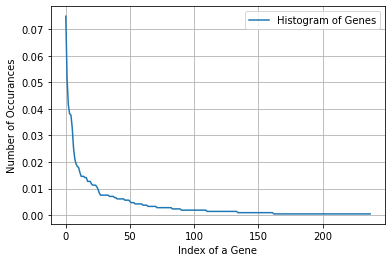

In [18]:
# ANOTHER WAY TO LOOK AT HTIS DATA IS TO PLOT A HISTOGRAM

s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


### CONCLUSIONS:
1. This is a skewed distribution
2. Only few genes make up majority of total genes 

**FURTHER BETTER WAY OF ANALYSING IS TO DRAW Cumulative Distribution Function**

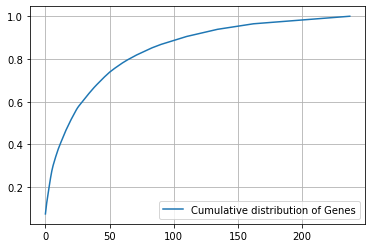

In [19]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()


**CONCLUSION:** 
 * TOP 50 GENES contribute to **~ 75%** of all genes !

## Q3. How to featurize this Gene feature ?
* ML models work best with numebrs, so feature transformation of categorical variables becomes important 
* there are two ways we can featurize this variable

1. **One hot Encoding**
2. **Response coding[also called MEAN VALUE REPLACEMENT]**

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, 

* **one-hot encoding is better for Logistic regression, Linear SVM**

* **Response coding is better for Random Forests, NB**

In [20]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))



In [21]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [22]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene']) # why fit_transform here but transform in other areas?
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])


In [23]:
train_df['Gene'].head()


1478     FGFR2
814      ERCC2
1804      ARAF
1269    PIK3R2
1693      PMS2
Name: Gene, dtype: object

In [24]:
gene_vectorizer.get_feature_names()


['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',

In [25]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)


train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 237)


## Q4. How good is this gene feature in predicting y_i?
* We want to know this, because if it isn't good, we can discard it. 

* We will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

* We'll use ***SGD classifier***, which is a general purpose classifier using which I CAN DO LOGISTIC REGRESSION and LINEAR SVM too 


For values of alpha =  1e-05 The log loss is: 1.2236482407634066
For values of alpha =  0.0001 The log loss is: 1.2202153265307827
For values of alpha =  0.001 The log loss is: 1.2716392870442403
For values of alpha =  0.01 The log loss is: 1.3755774696971121
For values of alpha =  0.1 The log loss is: 1.4554801284501888
For values of alpha =  1 The log loss is: 1.4877516925365861


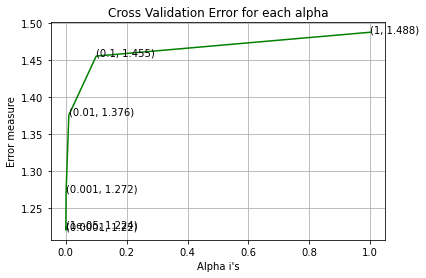

For values of best alpha =  0.0001 The train log loss is: 0.9745569629889091
For values of best alpha =  0.0001 The cross validation log loss is: 1.2202153265307827
For values of best alpha =  0.0001 The test log loss is: 1.2068084650562407


In [26]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42) # training a SGD classifier with loss = LOG , L2 penalty
                                                                         # alpha (lambda) = i (trying various values of alpha  )
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    
    # calibrated classifier : used to apply sigmoid calibration/isotonic regression, to already predicted class labels ; 
    # it converts them into probabilites 
    
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
     
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


**NOTE:**
    
* my random model has log loss of ~2.5
* my current feature gives a log loss (after LR and calibration) -> 1.18 ->much lower than 2.5: so its useful feature
* gap between my log loss values for train, test and cross validation is not much : 
thankfully, that tells me that I havent overfit my mode(comparing train and CV-->train log loss is not too low)

## Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

* Ans. Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

## Q6 How many data points in Test and CV dataset are covered by genes in train dataset?

In [27]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)




Q6. How many data points in Test and CV datasets are covered by the  238  genes in train dataset?
Ans
1. In test data 649 out of 665 : 97.59398496240601
2. In cross validation data 514 out of  532 : 96.61654135338345


### 3.2.2 Univariate Analysis on Variation Feature

## Q7. Variation, What type of feature is it ?

#### Ans. Variation is a categorical variable

## Q8. How many categories are there?

In [28]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head())

Number of Unique Variations : 1934
Truncating_Mutations    63
Deletion                49
Amplification           44
Fusions                 20
Overexpression           3
Name: Variation, dtype: int64


In [29]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)


Ans: There are 1934 different categories of variations in the train data, and they are distibuted as follows


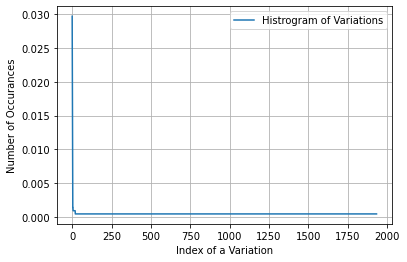

In [30]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

# we note that our graph is dropping v.v . fast 

[0.02966102 0.0527307  0.07344633 ... 0.99905838 0.99952919 1.        ]


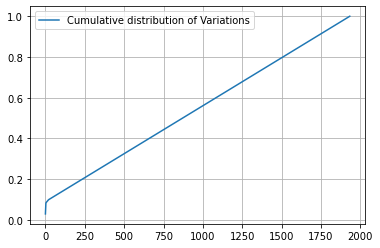

In [31]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

# a straight line CDF means most variations occur once or twice only

## Q9. How to featurize this Variation feature ?

### Ans.There are two ways we can featurize this variable check out this video: 
1. One hot Encoding
2. Response coding

We will be using both these methods to featurize the Variation Feature

In [32]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [33]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)


train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [34]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])



In [1]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

NameError: name 'train_variation_feature_onehotCoding' is not defined

### Q10. How good is this Variation feature in predicting y_i?

* Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.720919212462944
For values of alpha =  0.0001 The log loss is: 1.7161461091089807
For values of alpha =  0.001 The log loss is: 1.7230974455603532
For values of alpha =  0.01 The log loss is: 1.730256712508602
For values of alpha =  0.1 The log loss is: 1.7344019457855955
For values of alpha =  1 The log loss is: 1.7350251851603926


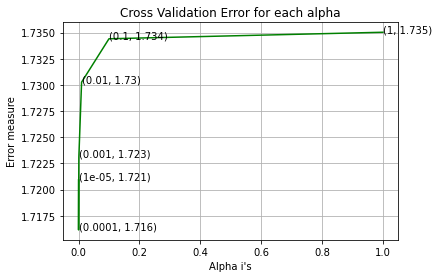

For values of best alpha =  0.0001 The train log loss is: 0.6557706338431477
For values of best alpha =  0.0001 The cross validation log loss is: 1.7161461091089807
For values of best alpha =  0.0001 The test log loss is: 1.7119882505098598


In [36]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


**CONCLUSIONS:**
1. as test log loss is < 2.5: this feature is useful 
2. diff in CV and training is much more than in case of gene feature. so comparatively this feature is more unstable
3. since most of datapoints in variation feature,occured 1 or 2 times only, the chances are HIGH that many datapoints in 
    train set under variation feature will NOT be present in test dataset and vice versa(similar for Dcv also)

### Q11. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

* Ans. Not sure! But lets be very sure using the below analysis.

In [37]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)



Q12. How many data points are covered by total  1934  genes in test and cross validation data sets?
Ans
1. In test data 64 out of 665 : 9.624060150375941
2. In cross validation data 64 out of  532 : 12.030075187969924


* i.e only 10% of test data points overalp with training data  
* similar story with Dcv 
* this tells that this feature is quite unstable !

**NOTE**: 
* so log loss shows that this feature is **useful**
* instablility shows that this feature is **NOT useful**
* we conclude that this feature IS USEFUL: as it brought down log loss value compared to random model **significantly**

### 3.2.3 Univariate Analysis on Text Feature

* How many unique words are present in train data?
* How are word frequencies distributed?
* How to featurize text field?
* Is the text feature useful in predicitng y_i?
* Is the text feature stable across train, test and CV datasets?

In [38]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word
c = 0 
def extract_dictionary_paddle(cls_text):
    global c 
    D = defaultdict(lambda:0)
    for index, row in cls_text.iterrows():
        print(f'processing {c} times here')
        c+=1
        if type(row['TEXT'])==str:
            for words in row["TEXT"].split():
                D[words] +=1
         
    return D



In [39]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            if type(row['TEXT'])==str:
                for word in row['TEXT'].split():
                    sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
                text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
                row_index += 1
    return text_feature_responseCoding




In [40]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'].values.astype(str))
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))




Total number of unique words in train data : 52983


In [41]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class

for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

processing 0 times here
processing 1 times here
processing 2 times here
processing 3 times here
processing 4 times here
processing 5 times here
processing 6 times here
processing 7 times here
processing 8 times here
processing 9 times here
processing 10 times here
processing 11 times here
processing 12 times here
processing 13 times here
processing 14 times here
processing 15 times here
processing 16 times here
processing 17 times here
processing 18 times here
processing 19 times here
processing 20 times here
processing 21 times here
processing 22 times here
processing 23 times here
processing 24 times here
processing 25 times here
processing 26 times here
processing 27 times here
processing 28 times here
processing 29 times here
processing 30 times here
processing 31 times here
processing 32 times here
processing 33 times here
processing 34 times here
processing 35 times here
processing 36 times here
processing 37 times here
processing 38 times here
processing 39 times here
processing

processing 330 times here
processing 331 times here
processing 332 times here
processing 333 times here
processing 334 times here
processing 335 times here
processing 336 times here
processing 337 times here
processing 338 times here
processing 339 times here
processing 340 times here
processing 341 times here
processing 342 times here
processing 343 times here
processing 344 times here
processing 345 times here
processing 346 times here
processing 347 times here
processing 348 times here
processing 349 times here
processing 350 times here
processing 351 times here
processing 352 times here
processing 353 times here
processing 354 times here
processing 355 times here
processing 356 times here
processing 357 times here
processing 358 times here
processing 359 times here
processing 360 times here
processing 361 times here
processing 362 times here
processing 363 times here
processing 364 times here
processing 365 times here
processing 366 times here
processing 367 times here
processing 3

processing 652 times here
processing 653 times here
processing 654 times here
processing 655 times here
processing 656 times here
processing 657 times here
processing 658 times here
processing 659 times here
processing 660 times here
processing 661 times here
processing 662 times here
processing 663 times here
processing 664 times here
processing 665 times here
processing 666 times here
processing 667 times here
processing 668 times here
processing 669 times here
processing 670 times here
processing 671 times here
processing 672 times here
processing 673 times here
processing 674 times here
processing 675 times here
processing 676 times here
processing 677 times here
processing 678 times here
processing 679 times here
processing 680 times here
processing 681 times here
processing 682 times here
processing 683 times here
processing 684 times here
processing 685 times here
processing 686 times here
processing 687 times here
processing 688 times here
processing 689 times here
processing 6

processing 969 times here
processing 970 times here
processing 971 times here
processing 972 times here
processing 973 times here
processing 974 times here
processing 975 times here
processing 976 times here
processing 977 times here
processing 978 times here
processing 979 times here
processing 980 times here
processing 981 times here
processing 982 times here
processing 983 times here
processing 984 times here
processing 985 times here
processing 986 times here
processing 987 times here
processing 988 times here
processing 989 times here
processing 990 times here
processing 991 times here
processing 992 times here
processing 993 times here
processing 994 times here
processing 995 times here
processing 996 times here
processing 997 times here
processing 998 times here
processing 999 times here
processing 1000 times here
processing 1001 times here
processing 1002 times here
processing 1003 times here
processing 1004 times here
processing 1005 times here
processing 1006 times here
proce

processing 1303 times here
processing 1304 times here
processing 1305 times here
processing 1306 times here
processing 1307 times here
processing 1308 times here
processing 1309 times here
processing 1310 times here
processing 1311 times here
processing 1312 times here
processing 1313 times here
processing 1314 times here
processing 1315 times here
processing 1316 times here
processing 1317 times here
processing 1318 times here
processing 1319 times here
processing 1320 times here
processing 1321 times here
processing 1322 times here
processing 1323 times here
processing 1324 times here
processing 1325 times here
processing 1326 times here
processing 1327 times here
processing 1328 times here
processing 1329 times here
processing 1330 times here
processing 1331 times here
processing 1332 times here
processing 1333 times here
processing 1334 times here
processing 1335 times here
processing 1336 times here
processing 1337 times here
processing 1338 times here
processing 1339 times here
p

processing 1622 times here
processing 1623 times here
processing 1624 times here
processing 1625 times here
processing 1626 times here
processing 1627 times here
processing 1628 times here
processing 1629 times here
processing 1630 times here
processing 1631 times here
processing 1632 times here
processing 1633 times here
processing 1634 times here
processing 1635 times here
processing 1636 times here
processing 1637 times here
processing 1638 times here
processing 1639 times here
processing 1640 times here
processing 1641 times here
processing 1642 times here
processing 1643 times here
processing 1644 times here
processing 1645 times here
processing 1646 times here
processing 1647 times here
processing 1648 times here
processing 1649 times here
processing 1650 times here
processing 1651 times here
processing 1652 times here
processing 1653 times here
processing 1654 times here
processing 1655 times here
processing 1656 times here
processing 1657 times here
processing 1658 times here
p

processing 1933 times here
processing 1934 times here
processing 1935 times here
processing 1936 times here
processing 1937 times here
processing 1938 times here
processing 1939 times here
processing 1940 times here
processing 1941 times here
processing 1942 times here
processing 1943 times here
processing 1944 times here
processing 1945 times here
processing 1946 times here
processing 1947 times here
processing 1948 times here
processing 1949 times here
processing 1950 times here
processing 1951 times here
processing 1952 times here
processing 1953 times here
processing 1954 times here
processing 1955 times here
processing 1956 times here
processing 1957 times here
processing 1958 times here
processing 1959 times here
processing 1960 times here
processing 1961 times here
processing 1962 times here
processing 1963 times here
processing 1964 times here
processing 1965 times here
processing 1966 times here
processing 1967 times here
processing 1968 times here
processing 1969 times here
p

processing 2275 times here
processing 2276 times here
processing 2277 times here
processing 2278 times here
processing 2279 times here
processing 2280 times here
processing 2281 times here
processing 2282 times here
processing 2283 times here
processing 2284 times here
processing 2285 times here
processing 2286 times here
processing 2287 times here
processing 2288 times here
processing 2289 times here
processing 2290 times here
processing 2291 times here
processing 2292 times here
processing 2293 times here
processing 2294 times here
processing 2295 times here
processing 2296 times here
processing 2297 times here
processing 2298 times here
processing 2299 times here
processing 2300 times here
processing 2301 times here
processing 2302 times here
processing 2303 times here
processing 2304 times here
processing 2305 times here
processing 2306 times here
processing 2307 times here
processing 2308 times here
processing 2309 times here
processing 2310 times here
processing 2311 times here
p

processing 2595 times here
processing 2596 times here
processing 2597 times here
processing 2598 times here
processing 2599 times here
processing 2600 times here
processing 2601 times here
processing 2602 times here
processing 2603 times here
processing 2604 times here
processing 2605 times here
processing 2606 times here
processing 2607 times here
processing 2608 times here
processing 2609 times here
processing 2610 times here
processing 2611 times here
processing 2612 times here
processing 2613 times here
processing 2614 times here
processing 2615 times here
processing 2616 times here
processing 2617 times here
processing 2618 times here
processing 2619 times here
processing 2620 times here
processing 2621 times here
processing 2622 times here
processing 2623 times here
processing 2624 times here
processing 2625 times here
processing 2626 times here
processing 2627 times here
processing 2628 times here
processing 2629 times here
processing 2630 times here
processing 2631 times here
p

processing 2927 times here
processing 2928 times here
processing 2929 times here
processing 2930 times here
processing 2931 times here
processing 2932 times here
processing 2933 times here
processing 2934 times here
processing 2935 times here
processing 2936 times here
processing 2937 times here
processing 2938 times here
processing 2939 times here
processing 2940 times here
processing 2941 times here
processing 2942 times here
processing 2943 times here
processing 2944 times here
processing 2945 times here
processing 2946 times here
processing 2947 times here
processing 2948 times here
processing 2949 times here
processing 2950 times here
processing 2951 times here
processing 2952 times here
processing 2953 times here
processing 2954 times here
processing 2955 times here
processing 2956 times here
processing 2957 times here
processing 2958 times here
processing 2959 times here
processing 2960 times here
processing 2961 times here
processing 2962 times here
processing 2963 times here
p

processing 3284 times here
processing 3285 times here
processing 3286 times here
processing 3287 times here
processing 3288 times here
processing 3289 times here
processing 3290 times here
processing 3291 times here
processing 3292 times here
processing 3293 times here
processing 3294 times here
processing 3295 times here
processing 3296 times here
processing 3297 times here
processing 3298 times here
processing 3299 times here
processing 3300 times here
processing 3301 times here
processing 3302 times here
processing 3303 times here
processing 3304 times here
processing 3305 times here
processing 3306 times here
processing 3307 times here
processing 3308 times here
processing 3309 times here
processing 3310 times here
processing 3311 times here
processing 3312 times here
processing 3313 times here
processing 3314 times here
processing 3315 times here
processing 3316 times here
processing 3317 times here
processing 3318 times here
processing 3319 times here
processing 3320 times here
p

processing 3632 times here
processing 3633 times here
processing 3634 times here
processing 3635 times here
processing 3636 times here
processing 3637 times here
processing 3638 times here
processing 3639 times here
processing 3640 times here
processing 3641 times here
processing 3642 times here
processing 3643 times here
processing 3644 times here
processing 3645 times here
processing 3646 times here
processing 3647 times here
processing 3648 times here
processing 3649 times here
processing 3650 times here
processing 3651 times here
processing 3652 times here
processing 3653 times here
processing 3654 times here
processing 3655 times here
processing 3656 times here
processing 3657 times here
processing 3658 times here
processing 3659 times here
processing 3660 times here
processing 3661 times here
processing 3662 times here
processing 3663 times here
processing 3664 times here
processing 3665 times here
processing 3666 times here
processing 3667 times here
processing 3668 times here
p

processing 3939 times here
processing 3940 times here
processing 3941 times here
processing 3942 times here
processing 3943 times here
processing 3944 times here
processing 3945 times here
processing 3946 times here
processing 3947 times here
processing 3948 times here
processing 3949 times here
processing 3950 times here
processing 3951 times here
processing 3952 times here
processing 3953 times here
processing 3954 times here
processing 3955 times here
processing 3956 times here
processing 3957 times here
processing 3958 times here
processing 3959 times here
processing 3960 times here
processing 3961 times here
processing 3962 times here
processing 3963 times here
processing 3964 times here
processing 3965 times here
processing 3966 times here
processing 3967 times here
processing 3968 times here
processing 3969 times here
processing 3970 times here
processing 3971 times here
processing 3972 times here
processing 3973 times here
processing 3974 times here
processing 3975 times here
p

In [42]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [43]:

# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [44]:
# performing feature normalization
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# performing feature normalization
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# performing feature normalization
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [45]:

sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [46]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur)) ;

Counter({3: 4975, 4: 3437, 5: 3174, 6: 2767, 8: 1978, 7: 1964, 9: 1689, 10: 1663, 12: 1362, 11: 1359, 13: 857, 14: 827, 16: 806, 15: 762, 20: 694, 18: 688, 17: 641, 24: 600, 22: 536, 21: 515, 19: 485, 25: 387, 30: 379, 23: 375, 28: 372, 39: 338, 27: 336, 26: 330, 35: 293, 29: 281, 32: 279, 49: 273, 33: 272, 31: 255, 40: 251, 48: 240, 36: 236, 37: 225, 34: 223, 38: 217, 42: 213, 44: 201, 46: 168, 50: 165, 51: 162, 45: 162, 43: 161, 56: 159, 52: 158, 41: 158, 54: 148, 53: 143, 55: 141, 57: 140, 60: 137, 47: 127, 62: 126, 64: 120, 66: 116, 63: 111, 61: 110, 70: 106, 65: 106, 58: 106, 59: 104, 71: 103, 67: 94, 72: 92, 69: 88, 96: 87, 77: 87, 78: 86, 73: 84, 68: 84, 88: 83, 84: 83, 76: 77, 90: 76, 85: 75, 80: 75, 74: 74, 98: 73, 82: 72, 99: 69, 114: 68, 81: 68, 79: 68, 86: 67, 75: 65, 102: 63, 120: 61, 100: 61, 92: 61, 113: 60, 97: 60, 87: 60, 83: 60, 101: 57, 110: 55, 89: 55, 144: 53, 108: 53, 94: 53, 93: 53, 109: 52, 103: 52, 105: 50, 91: 50, 106: 47, 115: 45, 121: 44, 111: 44, 95: 44, 13

For values of alpha =  1e-05 The log loss is: 1.2385417326387416
For values of alpha =  0.0001 The log loss is: 1.1088712846893962
For values of alpha =  0.001 The log loss is: 1.1255276284929858
For values of alpha =  0.01 The log loss is: 1.2978358207026233
For values of alpha =  0.1 The log loss is: 1.4904887560801838
For values of alpha =  1 The log loss is: 1.682398824617481


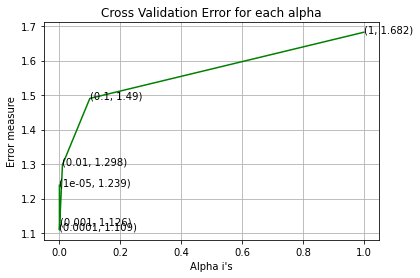

For values of best alpha =  0.0001 The train log loss is: 0.6549473301722225
For values of best alpha =  0.0001 The cross validation log loss is: 1.1088712846893962
For values of best alpha =  0.0001 The test log loss is: 1.1903223399388372


In [47]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Q. Is the Text feature stable across all the data sets (Test, Train, Cross validation)?

* Ans. Yes, it seems like!

In [48]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [49]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.085 % of word of test data appeared in train data
97.517 % of word of Cross Validation appeared in train data


### 4. Machine Learning Models

In [50]:
# we plot some functions for our ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [51]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [52]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### STACKING THE 3 TYPES OF CLASSIFIERS 

In [53]:
# merging gene, variance and text features

# building train, test and cross validation data sets

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [54]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55184)
(number of data points * number of features) in test data =  (665, 55184)
(number of data points * number of features) in cross validation data = (532, 55184)


In [55]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## 4.1. Base Line Model

### 4.1.1. Naive Bayes

#### 4.1.1.1. Hyper parameter tuning

for alpha = 1e-05
Log Loss : 1.2517145179520548
for alpha = 0.0001
Log Loss : 1.2539498214135079
for alpha = 0.001
Log Loss : 1.2533966250247333
for alpha = 0.1
Log Loss : 1.2417436412181484
for alpha = 1
Log Loss : 1.3224012119278272
for alpha = 10
Log Loss : 1.464828561708556
for alpha = 100
Log Loss : 1.420933610543135
for alpha = 1000
Log Loss : 1.3493461057537344


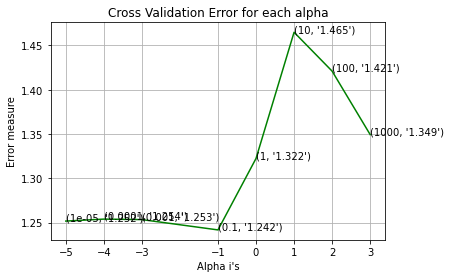

For values of best alpha =  0.1 The train log loss is: 0.8434159551105421
For values of best alpha =  0.1 The cross validation log loss is: 1.2417436412181484
For values of best alpha =  0.1 The test log loss is: 1.3198818781842012


In [56]:

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.1.1.2. Testing the model with best hyper paramters

Log Loss : 1.2417436412181484
Number of missclassified point : 0.3815789473684211
-------------------- Confusion matrix --------------------


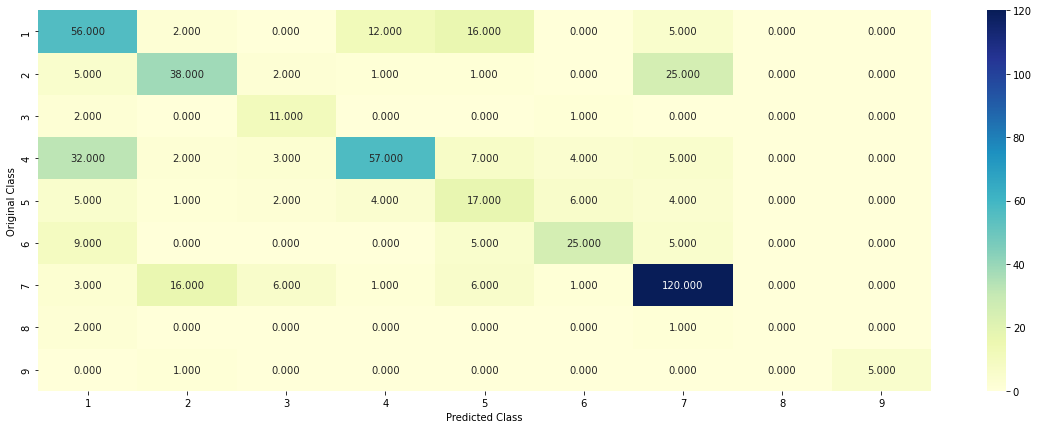

-------------------- Precision matrix (Columm Sum=1) --------------------


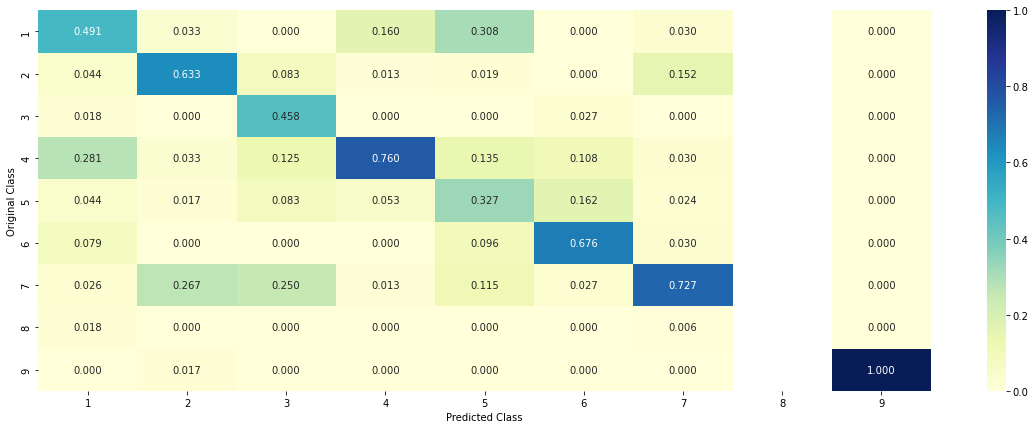

-------------------- Recall matrix (Row sum=1) --------------------


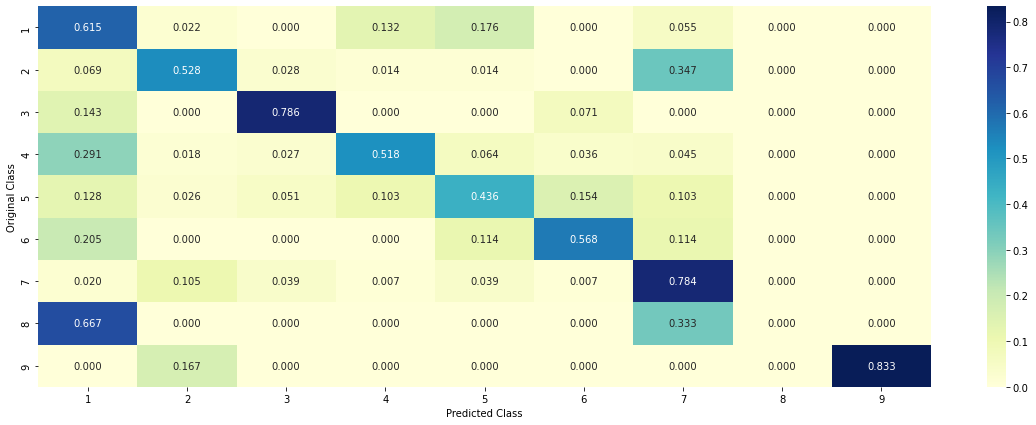

In [57]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)


sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)


# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### 4.1.1.3. Feature Importance, Correctly classified point

In [58]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])


print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))


print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0796 0.3425 0.0142 0.1109 0.0382 0.0388 0.3653 0.0052 0.0054]]
Actual Class : 5
--------------------------------------------------
17 Text feature [kinase] present in test data point [True]
18 Text feature [activating] present in test data point [True]
19 Text feature [presence] present in test data point [True]
20 Text feature [downstream] present in test data point [True]
23 Text feature [inhibitor] present in test data point [True]
24 Text feature [recently] present in test data point [True]
25 Text feature [contrast] present in test data point [True]
26 Text feature [well] present in test data point [True]
27 Text feature [independent] present in test data point [True]
28 Text feature [mutations] present in test data point [True]
29 Text feature [previously] present in test data point [True]
30 Text feature [treated] present in test data point [True]
31 Text feature [however] present in test data point [True]
32 Text feature [e

### 4.1.1.4. Feature Importance, Incorrectly classified point

In [59]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 1
Predicted Class Probabilities: [[0.5905 0.0751 0.0133 0.1068 0.0361 0.0369 0.1313 0.0052 0.0049]]
Actual Class : 1
--------------------------------------------------
10 Text feature [dna] present in test data point [True]
12 Text feature [protein] present in test data point [True]
13 Text feature [one] present in test data point [True]
14 Text feature [function] present in test data point [True]
15 Text feature [type] present in test data point [True]
16 Text feature [two] present in test data point [True]
17 Text feature [sequence] present in test data point [True]
18 Text feature [affect] present in test data point [True]
19 Text feature [wild] present in test data point [True]
20 Text feature [sequences] present in test data point [True]
21 Text feature [possible] present in test data point [True]
22 Text feature [specific] present in test data point [True]
23 Text feature [containing] present in test data point [True]
24 Text feature [present] present in test da

## 4.2. K Nearest Neighbour Classification

### 4.2.1. Hyper parameter tuning

for alpha = 5
Log Loss : 1.1070862321249473
for alpha = 11
Log Loss : 1.1058242582073174
for alpha = 15
Log Loss : 1.11181586049319
for alpha = 21
Log Loss : 1.1336898889187303
for alpha = 31
Log Loss : 1.1326513965575598
for alpha = 41
Log Loss : 1.12891147910279
for alpha = 51
Log Loss : 1.1244858442839316
for alpha = 99
Log Loss : 1.1204647891728692


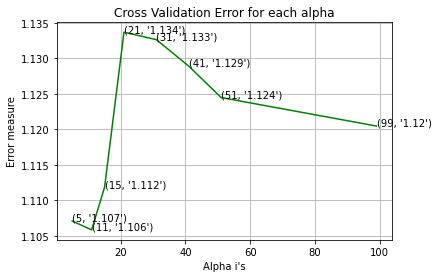

For values of best alpha =  11 The train log loss is: 0.6049556789077369
For values of best alpha =  11 The cross validation log loss is: 1.1058242582073174
For values of best alpha =  11 The test log loss is: 1.0778281650104453


In [60]:

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 4.2.2. Testing the model with best hyper paramters

Log loss : 1.1058242582073174
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


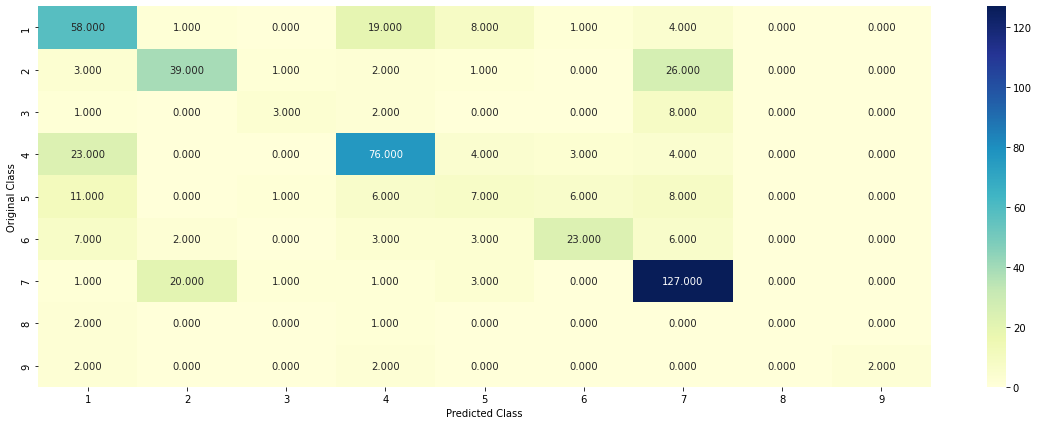

-------------------- Precision matrix (Columm Sum=1) --------------------


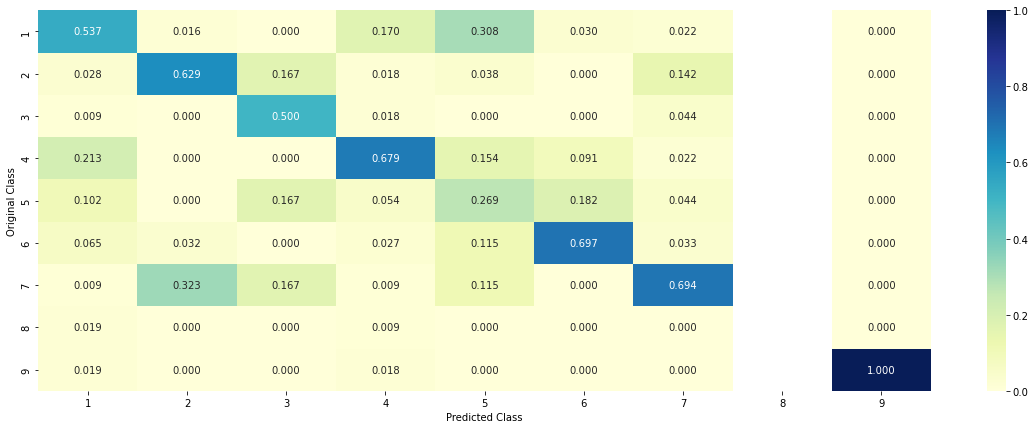

-------------------- Recall matrix (Row sum=1) --------------------


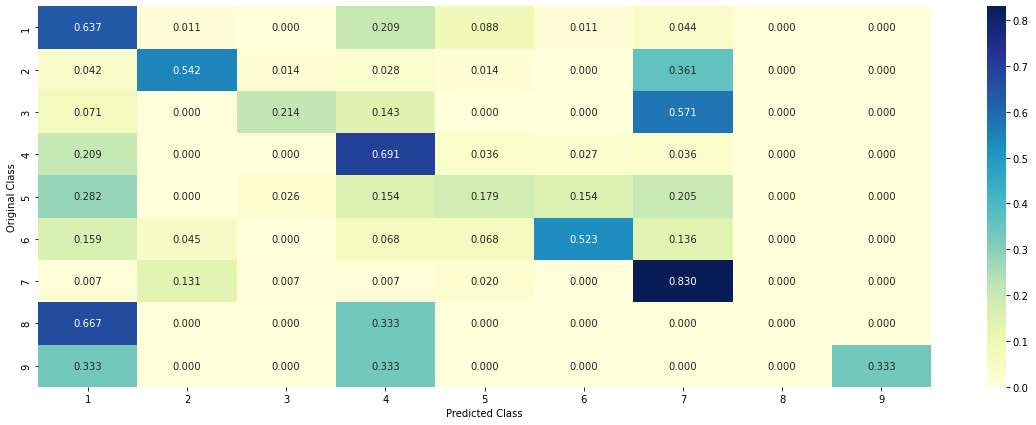

In [61]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

### 4.2.3.Sample Query point -1

In [62]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 5
The  11  nearest neighbours of the test points belongs to classes [2 6 5 5 2 7 7 5 7 5 2]
Fequency of nearest points : Counter({5: 4, 2: 3, 7: 3, 6: 1})


 ### 4.2.4. Sample Query Point-2

In [63]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [6 4 1 1 4 1 1 4 1 1 1]
Fequency of nearest points : Counter({1: 7, 4: 3, 6: 1})


## 4.3. Logistic Regression

### 4.3.1. With Class balancing

#### 4.3.1.1. Hyper paramter tuning

for alpha = 1e-06
Log Loss : 1.3180540220039387
for alpha = 1e-05
Log Loss : 1.2721740233239387
for alpha = 0.0001
Log Loss : 1.072038977752412
for alpha = 0.001
Log Loss : 1.0627365878086577
for alpha = 0.01
Log Loss : 1.1692299679535145
for alpha = 0.1
Log Loss : 1.511214448287223
for alpha = 1
Log Loss : 1.7156924256711987
for alpha = 10
Log Loss : 1.7408147077526606
for alpha = 100
Log Loss : 1.7434492675354505


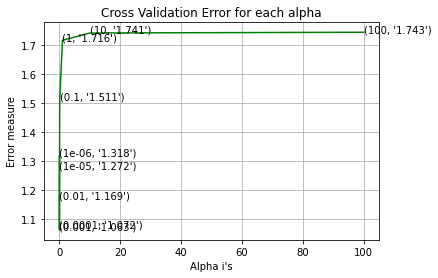

For values of best alpha =  0.001 The train log loss is: 0.5097293559881988
For values of best alpha =  0.001 The cross validation log loss is: 1.0627365878086577
For values of best alpha =  0.001 The test log loss is: 1.1258014059247805


In [64]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 4.3.1.2. Testing the model with best hyper paramters

Log loss : 1.0627365878086577
Number of mis-classified points : 0.34022556390977443
-------------------- Confusion matrix --------------------


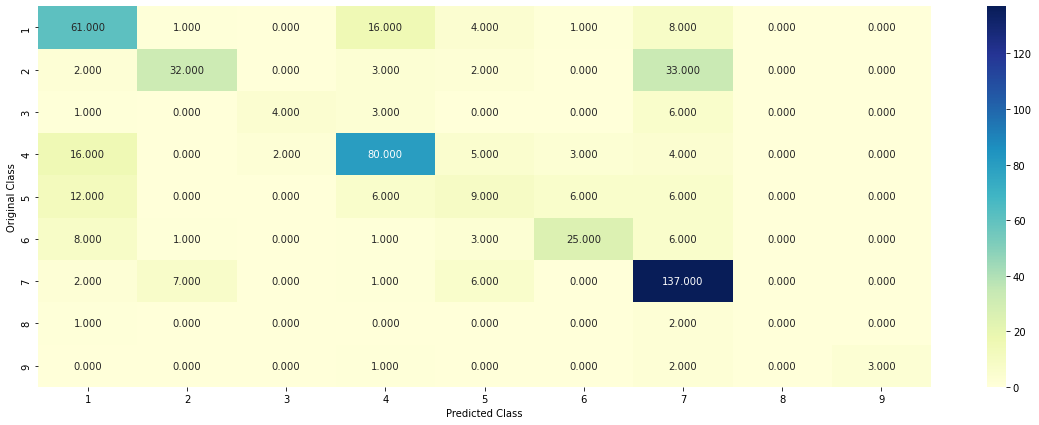

-------------------- Precision matrix (Columm Sum=1) --------------------


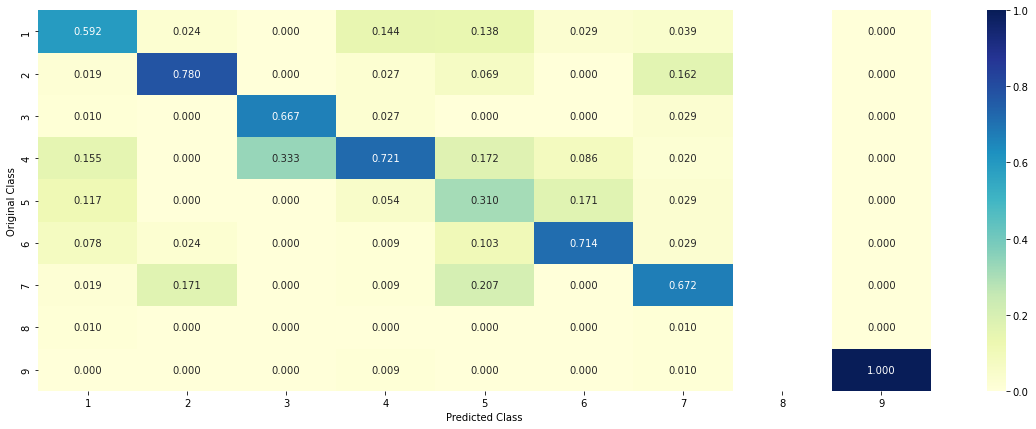

-------------------- Recall matrix (Row sum=1) --------------------


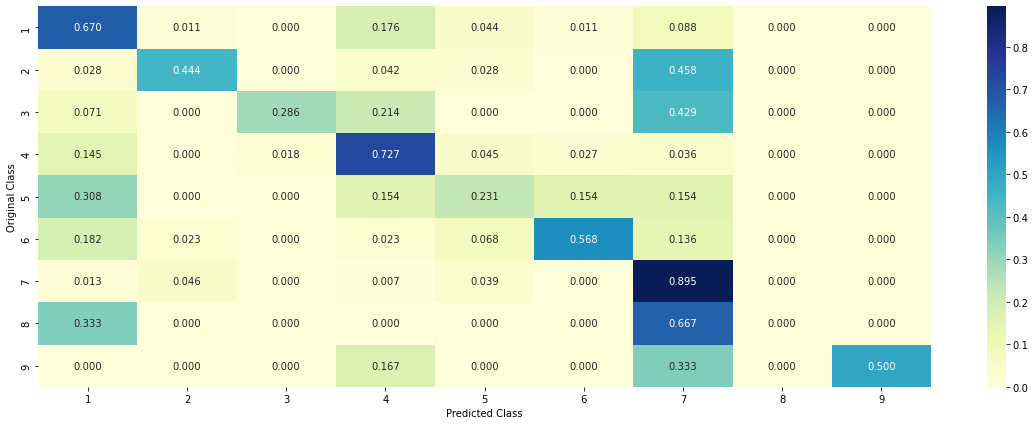

In [65]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### 4.3.1.3. Feature Importance

In [66]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

#### 4.3.1.3.1. Correctly Classified point

In [67]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0411 0.1865 0.0038 0.0155 0.0551 0.0105 0.6725 0.0119 0.0031]]
Actual Class : 5
--------------------------------------------------
34 Text feature [constitutive] present in test data point [True]
48 Text feature [nude] present in test data point [True]
75 Text feature [transforming] present in test data point [True]
114 Text feature [550] present in test data point [True]
135 Text feature [ser235] present in test data point [True]
152 Text feature [downstream] present in test data point [True]
181 Text feature [balb] present in test data point [True]
188 Text feature [activating] present in test data point [True]
248 Text feature [oncogene] present in test data point [True]
252 Text feature [phosphorylation] present in test data point [True]
273 Text feature [doses] present in test data point [True]
296 Text feature [subcutaneously] present in test data point [True]
345 Text feature [inhibited] present in test data point [True]
373

#### 4.3.1.3.2. Incorrectly Classified point

In [68]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 1
Predicted Class Probabilities: [[0.6454 0.0986 0.0054 0.1027 0.0212 0.0161 0.0988 0.0083 0.0034]]
Actual Class : 1
--------------------------------------------------
223 Text feature [figure5d] present in test data point [True]
342 Text feature [stop] present in test data point [True]
349 Text feature [premature] present in test data point [True]
Out of the top  500  features  3 are present in query point


### 4.3.2. Without Class balancing

#### 4.3.2.1. Hyper paramter tuning

for alpha = 1e-06
Log Loss : 1.3141192551680212
for alpha = 1e-05
Log Loss : 1.269035976660867
for alpha = 0.0001
Log Loss : 1.0765285222995153
for alpha = 0.001
Log Loss : 1.0801965258181825
for alpha = 0.01
Log Loss : 1.2412170747506388
for alpha = 0.1
Log Loss : 1.402405405838257
for alpha = 1
Log Loss : 1.6281931169807287


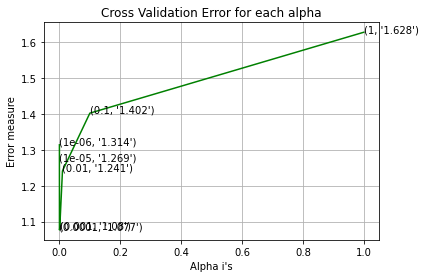

For values of best alpha =  0.0001 The train log loss is: 0.47582000314830836
For values of best alpha =  0.0001 The cross validation log loss is: 1.0765285222995153
For values of best alpha =  0.0001 The test log loss is: 1.1392187053242573


In [69]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### 4.3.2.2. Testing model with best hyper parameters

Log loss : 1.0765285222995153
Number of mis-classified points : 0.32894736842105265
-------------------- Confusion matrix --------------------


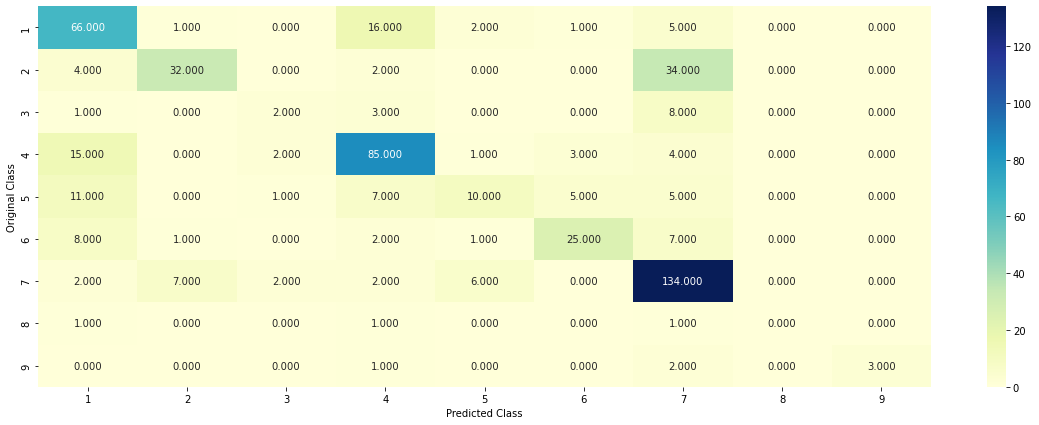

-------------------- Precision matrix (Columm Sum=1) --------------------


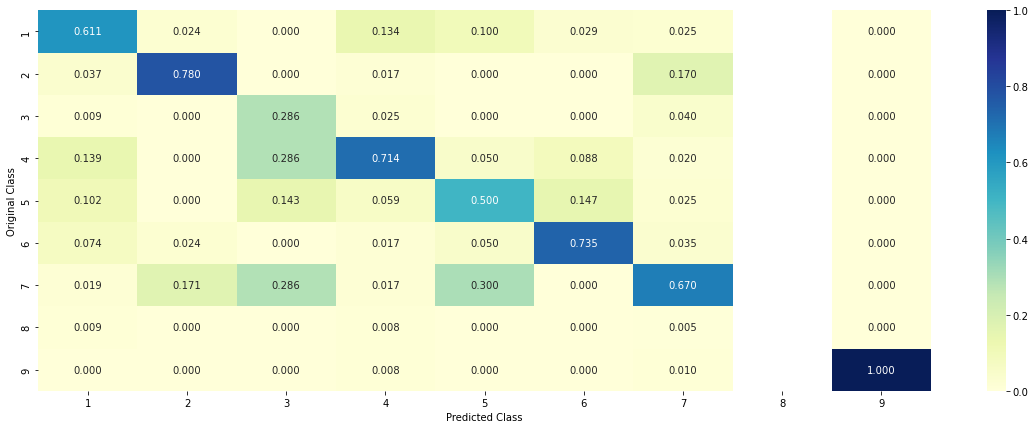

-------------------- Recall matrix (Row sum=1) --------------------


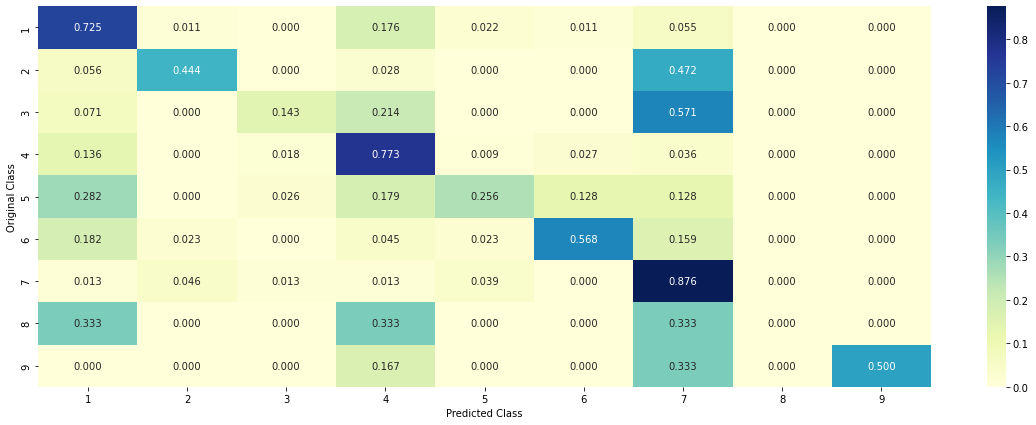

In [70]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### 4.3.2.3. Feature Importance, Correctly Classified point

In [71]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0929 0.1588 0.0034 0.0201 0.0566 0.0071 0.6477 0.0099 0.0035]]
Actual Class : 5
--------------------------------------------------
234 Text feature [550] present in test data point [True]
241 Text feature [ser235] present in test data point [True]
267 Text feature [transforming] present in test data point [True]
273 Text feature [constitutive] present in test data point [True]
384 Text feature [nude] present in test data point [True]
413 Text feature [balb] present in test data point [True]
454 Text feature [ser473] present in test data point [True]
467 Text feature [ile] present in test data point [True]
Out of the top  500  features  8 are present in query point


### 4.3.2.4. Feature Importance, Inorrectly Classified point

In [72]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 1
Predicted Class Probabilities: [[0.6574 0.1052 0.0053 0.0898 0.0261 0.0113 0.0935 0.0077 0.0035]]
Actual Class : 1
--------------------------------------------------
220 Text feature [figure5d] present in test data point [True]
443 Text feature [stop] present in test data point [True]
473 Text feature [variance] present in test data point [True]
Out of the top  500  features  3 are present in query point


## 4.4. Linear Support Vector Machines

### 4.4.1. Hyper paramter tuning

for C = 1e-05
Log Loss : 1.292305613002461
for C = 0.0001
Log Loss : 1.1881844184730408
for C = 0.001
Log Loss : 1.088262473053922
for C = 0.01
Log Loss : 1.1249844955970574
for C = 0.1
Log Loss : 1.4065314005638305
for C = 1
Log Loss : 1.7316787641832814
for C = 10
Log Loss : 1.7439667102374172
for C = 100
Log Loss : 1.7439668961048342


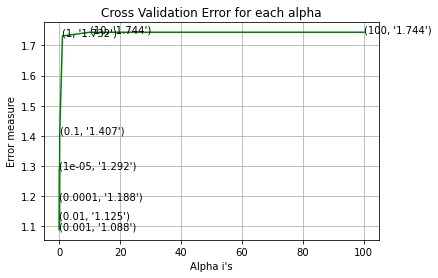

For values of best alpha =  0.001 The train log loss is: 0.518341911059382
For values of best alpha =  0.001 The cross validation log loss is: 1.088262473053922
For values of best alpha =  0.001 The test log loss is: 1.1503596924169446


In [73]:

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 4.4.2. Testing model with best hyper parameters

Log loss : 1.088262473053922
Number of mis-classified points : 0.325187969924812
-------------------- Confusion matrix --------------------


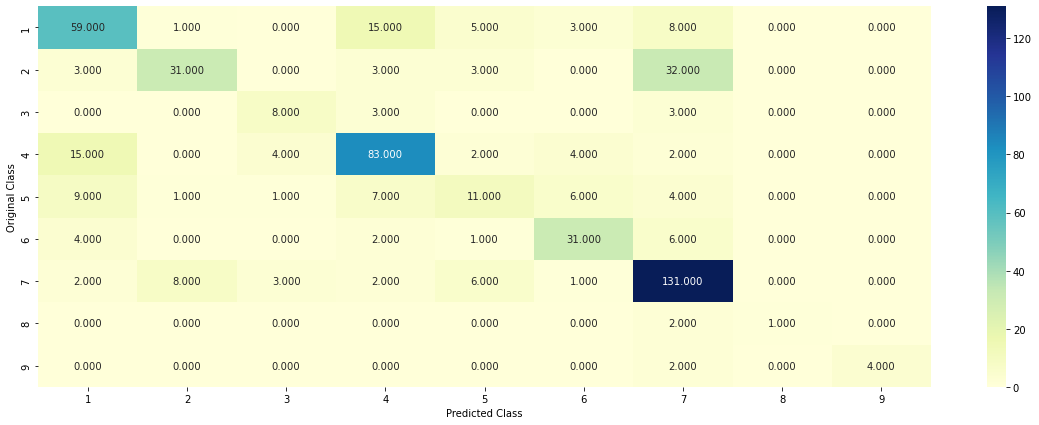

-------------------- Precision matrix (Columm Sum=1) --------------------


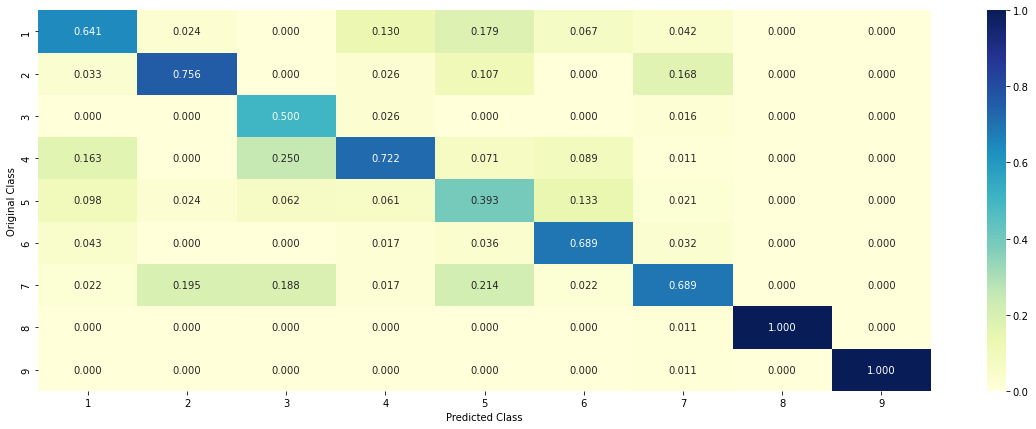

-------------------- Recall matrix (Row sum=1) --------------------


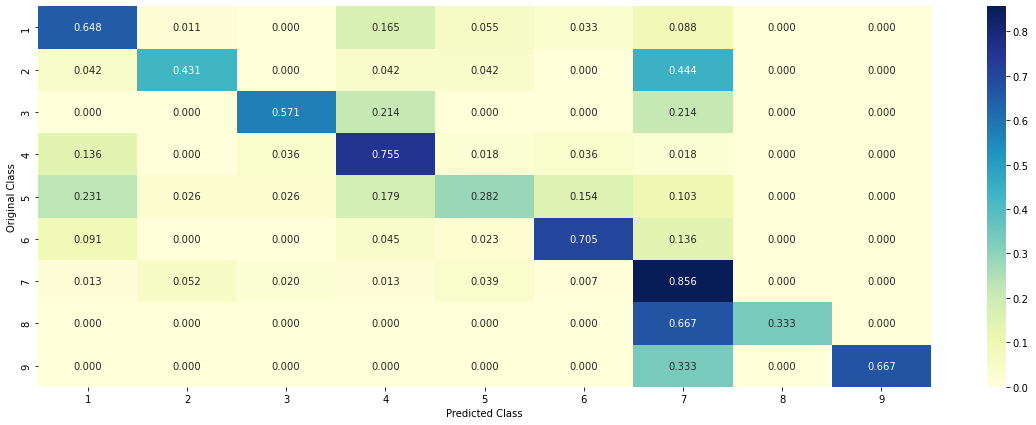

In [74]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 4.3.3. Feature Importance

#### 4.3.3.1. For Correctly classified point

In [75]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.2006 0.1138 0.0092 0.0321 0.1074 0.0238 0.4979 0.0075 0.0077]]
Actual Class : 5
--------------------------------------------------
247 Text feature [ile] present in test data point [True]
305 Text feature [transforming] present in test data point [True]
320 Text feature [550] present in test data point [True]
322 Text feature [ser235] present in test data point [True]
424 Text feature [ser473] present in test data point [True]
446 Text feature [constitutive] present in test data point [True]
449 Text feature [nude] present in test data point [True]
Out of the top  500  features  7 are present in query point


#### 4.3.3.2. For Incorrectly classified point

In [76]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 1
Predicted Class Probabilities: [[0.5689 0.1342 0.0096 0.094  0.0395 0.0258 0.1141 0.0076 0.0064]]
Actual Class : 1
--------------------------------------------------
259 Text feature [figure5d] present in test data point [True]
Out of the top  500  features  1 are present in query point


### 4.5 Random Forest Classifier

#### 4.5.1. Hyper paramter tuning (With One hot Encoding)

In [77]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 100 and max depth =  5
Log Loss : 1.248244695098149
for n_estimators = 100 and max depth =  10
Log Loss : 1.172989930263894
for n_estimators = 200 and max depth =  5
Log Loss : 1.2431193245234307
for n_estimators = 200 and max depth =  10
Log Loss : 1.1656384496205896
for n_estimators = 500 and max depth =  5
Log Loss : 1.2310929209961008
for n_estimators = 500 and max depth =  10
Log Loss : 1.1565283260986021
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2309187477512804
for n_estimators = 1000 and max depth =  10
Log Loss : 1.155601940223555
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2292265829833726
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1549518680384425
For values of best estimator =  2000 The train log loss is: 0.6851172908147953
For values of best estimator =  2000 The cross validation log loss is: 1.1549518680384425
For values of best estimator =  2000 The test log loss is: 1.1408421305380076


### 4.5.2. Testing model with best hyper parameters (One Hot Encoding)

Log loss : 1.1549518680384425
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


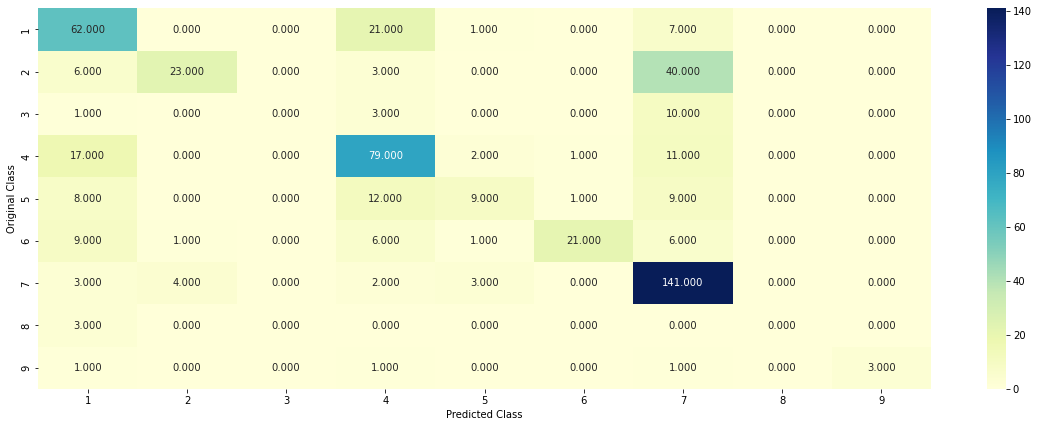

-------------------- Precision matrix (Columm Sum=1) --------------------


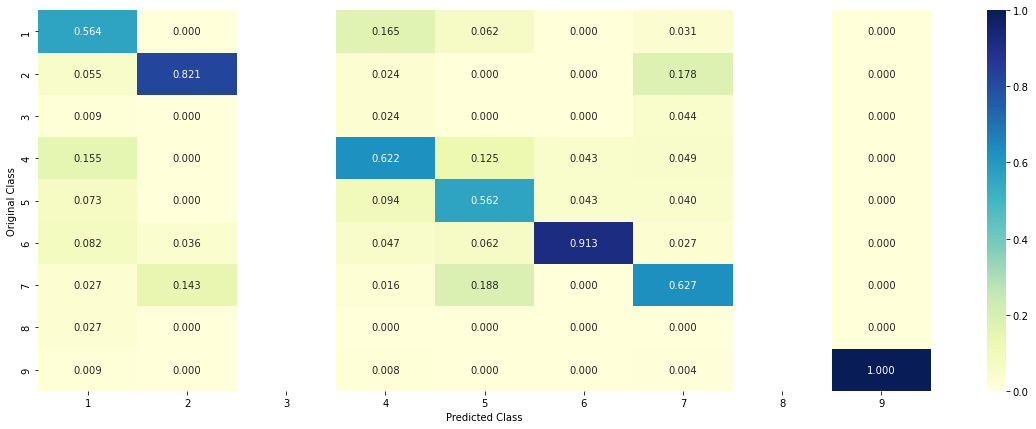

-------------------- Recall matrix (Row sum=1) --------------------


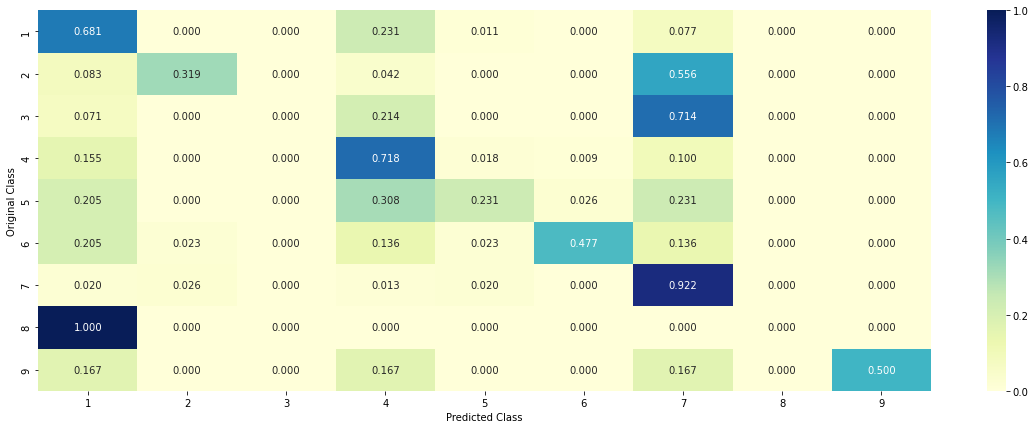

In [78]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 4.5.3. Feature Importance

#### 4.5.3.1. Correctly Classified point

In [81]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0479 0.164  0.0178 0.0476 0.043  0.0347 0.6325 0.0069 0.0057]]
Actual Class : 5
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [constitutive] present in test data point [True]
5 Text feature [activation] present in test data point [True]
6 Text feature [treatment] present in test data point [True]
9 Text feature [inhibitors] present in test data point [True]
10 Text feature [phosphorylation] present in test data point [True]
11 Text feature [inhibitor] present in test data point [True]
12 Text feature [therapy] present in test data point [True]
13 Text feature [function] present in test data point [True]
15 Text feature [growth] present in test data point [True]
16 Text feature [loss] present in test data point [True]
17 Text feature [akt] present in test data point [True]
18 Text feature [oncog

#### 4.5.3.2. Incorrectly Classified point

In [83]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 1
Predicted Class Probabilities: [[0.3625 0.1388 0.0232 0.1774 0.0627 0.0527 0.1585 0.013  0.0112]]
Actuall Class : 1
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [constitutive] present in test data point [True]
4 Text feature [suppressor] present in test data point [True]
5 Text feature [activation] present in test data point [True]
6 Text feature [treatment] present in test data point [True]
7 Text feature [activated] present in test data point [True]
8 Text feature [missense] present in test data point [True]
9 Text feature [inhibitors] present in test data point [True]
11 Text feature [inhibitor] present in test data point [True]
12 Text feature [therapy] present in test data point [True]
13 Text feature [function] present in test data point [True]
14 Text feature [nonsense] present in test data point [True]
16 Text feature [loss] present in test data point [True]
21 Text feature [brca1

#### 4.5.3. Hyper paramter tuning (With Response Coding)

In [85]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 10 and max depth =  2
Log Loss : 2.0490879424741313
for n_estimators = 10 and max depth =  3
Log Loss : 1.7044729802626108
for n_estimators = 10 and max depth =  5
Log Loss : 1.4854705201277805
for n_estimators = 10 and max depth =  10
Log Loss : 1.5935366323723827
for n_estimators = 50 and max depth =  2
Log Loss : 1.7085020236456883
for n_estimators = 50 and max depth =  3
Log Loss : 1.5644153598674828
for n_estimators = 50 and max depth =  5
Log Loss : 1.4390061143939596
for n_estimators = 50 and max depth =  10
Log Loss : 1.65821381594001
for n_estimators = 100 and max depth =  2
Log Loss : 1.5953600898249318
for n_estimators = 100 and max depth =  3
Log Loss : 1.5436513106453287
for n_estimators = 100 and max depth =  5
Log Loss : 1.4766300464823112
for n_estimators = 100 and max depth =  10
Log Loss : 1.6643368894217214
for n_estimators = 200 and max depth =  2
Log Loss : 1.671608217307489
for n_estimators = 200 and max depth =  3
Log Loss : 1.5364767893185527


### 4.5.4. Testing model with best hyper parameters (Response Coding)

Log loss : 1.4390061143939596
Number of mis-classified points : 0.5413533834586466
-------------------- Confusion matrix --------------------


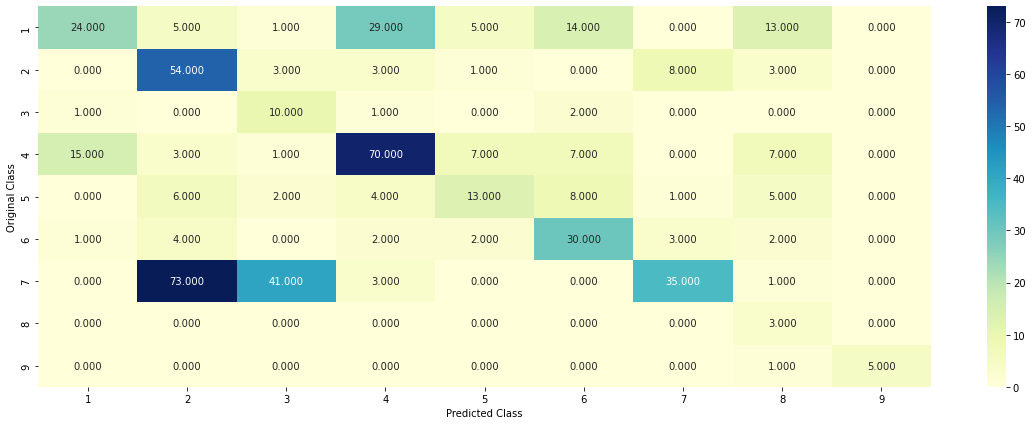

-------------------- Precision matrix (Columm Sum=1) --------------------


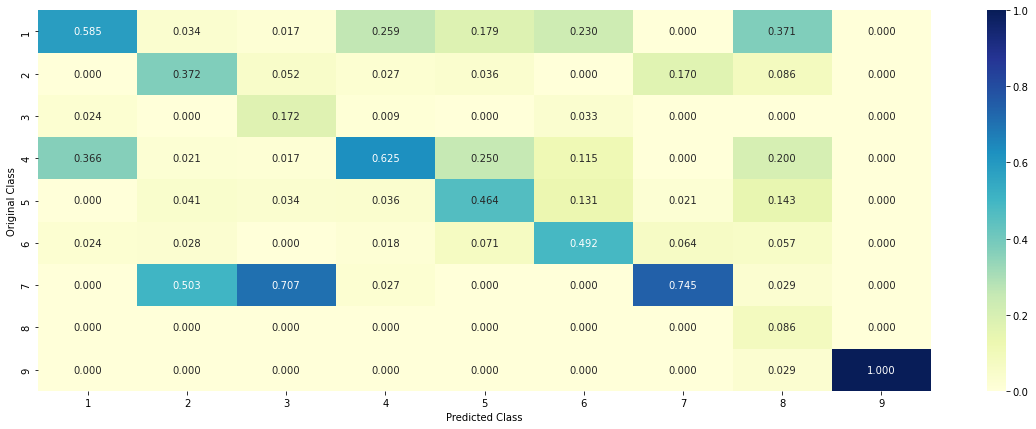

-------------------- Recall matrix (Row sum=1) --------------------


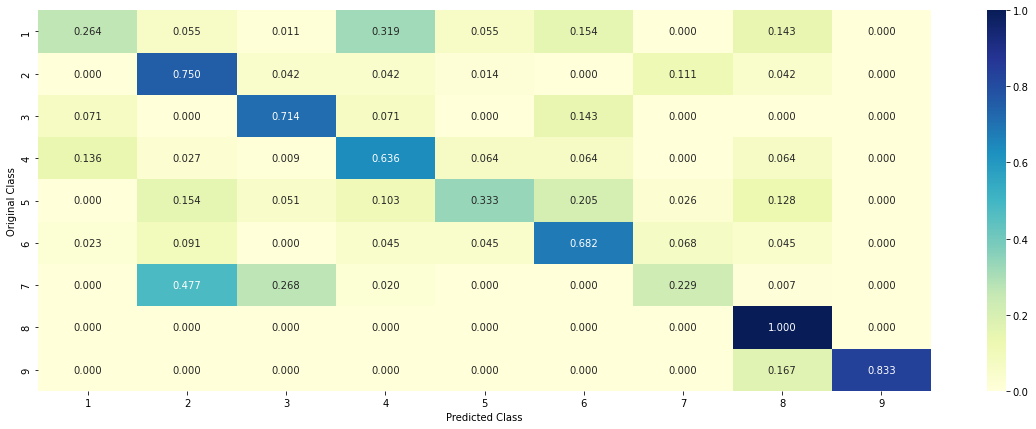

In [87]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)


### 4.5.5. Feature Importance

#### 4.5.5.1. Correctly Classified point

In [90]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0152 0.4593 0.1266 0.0178 0.0272 0.0379 0.2623 0.0322 0.0214]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


### 4.5.5.2. Incorrectly Classified point

In [92]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.8701 0.0046 0.0054 0.0799 0.0034 0.0181 0.0034 0.009  0.006 ]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


# THE END 